In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Load dataset
# Make sure to upload the 'Netflix Dataset.csv' file to your Colab environment first.
df = pd.read_csv("Netflix Dataset.csv")

# Preview
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (7789, 11)


,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [5]:
# Make column names consistent
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Parse Release_Date
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['year_added'] = df['release_date'].dt.year

# Normalize category (Movies / TV Shows)
df['category'] = df['category'].str.strip().str.title()

# Normalize duration into numeric
def parse_duration(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if 'min' in s:
        return int(s.split()[0])
    if 'season' in s.lower():
        return int(s.split()[0])
    return np.nan

df['duration_num'] = df['duration'].apply(parse_duration)

# Split genres (Type column)
df['genre_list'] = df['type'].fillna('Unknown').apply(lambda x: [g.strip() for g in str(x).split(',')])
df_genres = df.explode('genre_list').rename(columns={'genre_list':'genre'})

# Split countries
df_genres['country_list'] = df_genres['country'].fillna('Unknown').apply(lambda x: [c.strip() for c in str(x).split(',')])
df_clean = df_genres.explode('country_list').rename(columns={'country_list':'country_parsed'})

df_clean.head()

,show_id,category,title,director,cast,country,release_date,rating,duration,type,description,year_added,duration_num,genre,country_parsed
0,s1,Tv Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020.0,4,International TV Shows,Brazil
0,s1,Tv Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020.0,4,TV Dramas,Brazil
0,s1,Tv Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020.0,4,TV Sci-Fi & Fantasy,Brazil
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016.0,93,Dramas,Mexico
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016.0,93,International Movies,Mexico


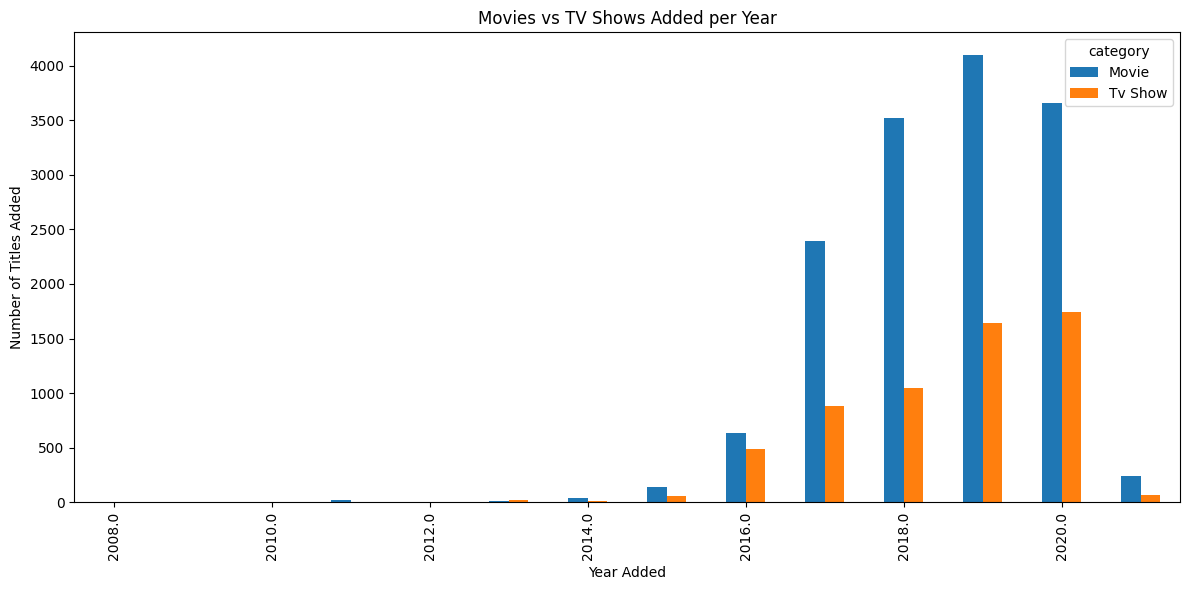

In [7]:
df_type_year = (
      df_clean.dropna(subset=['year_added'])
          .groupby(['year_added','category'])
              .size()
                  .unstack(fill_value=0)
                  )

df_type_year.plot(kind='bar', figsize=(12,6))
plt.xlabel("Year Added")
plt.ylabel("Number of Titles Added")
plt.title("Movies vs TV Shows Added per Year")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

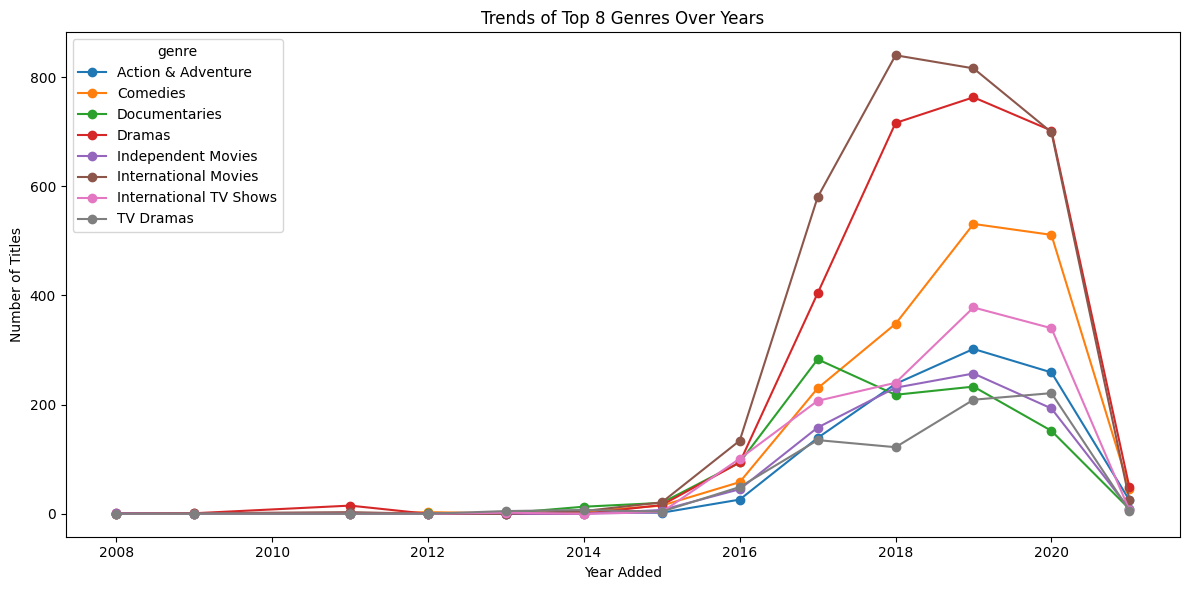

In [9]:
df_genre_year = (
      df_clean.dropna(subset=['year_added'])
          .groupby(['year_added','genre'])
              .size()
                  .reset_index(name='count')
                  )

# Top 8 genres
top_genres = df_genre_year.groupby('genre')['count'].sum().nlargest(8).index.tolist()
df_top_genres = df_genre_year[df_genre_year['genre'].isin(top_genres)]

pivot = df_top_genres.pivot(index='year_added', columns='genre', values='count').fillna(0)

pivot.plot(kind='line', marker='o', figsize=(12,6))
plt.xlabel("Year Added")
plt.ylabel("Number of Titles")
plt.title("Trends of Top 8 Genres Over Years")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

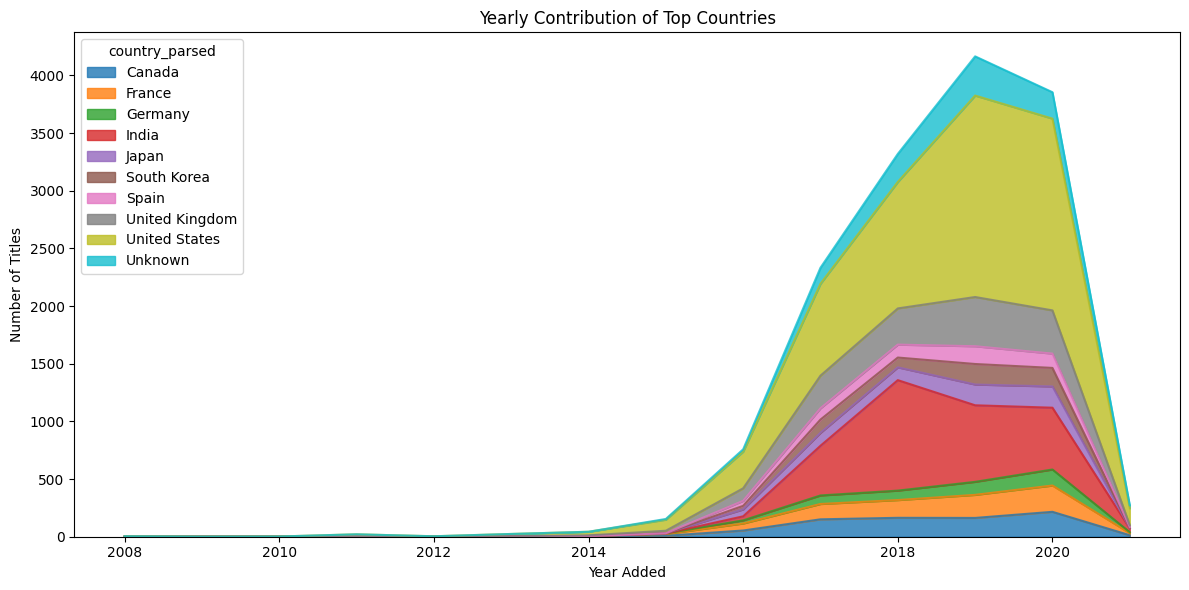

In [10]:
top_countries = df_clean['country_parsed'].value_counts().head(10).index.tolist()

df_country_year = df_clean[df_clean['country_parsed'].isin(top_countries) & df_clean['year_added'].notna()]
country_pivot = df_country_year.groupby(['year_added','country_parsed']).size().unstack(fill_value=0)

country_pivot.plot(kind='area', stacked=True, alpha=0.8, figsize=(12,6))
plt.xlabel("Year Added")
plt.ylabel("Number of Titles")
plt.title("Yearly Contribution of Top Countries")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()


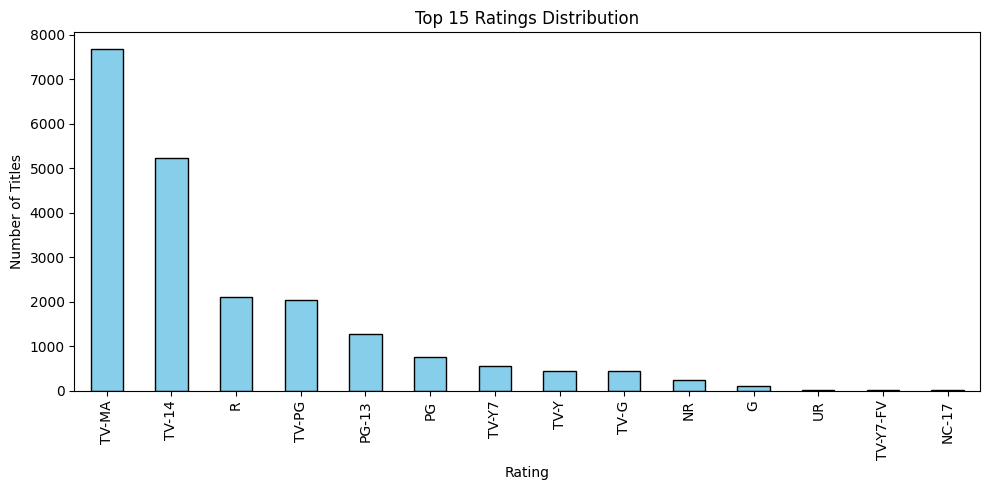

In [11]:
ratings_dist = df_clean['rating'].value_counts().head(15)

ratings_dist.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10,5))
plt.title("Top 15 Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Number of Titles")
plt.tight_layout()
plt.show()


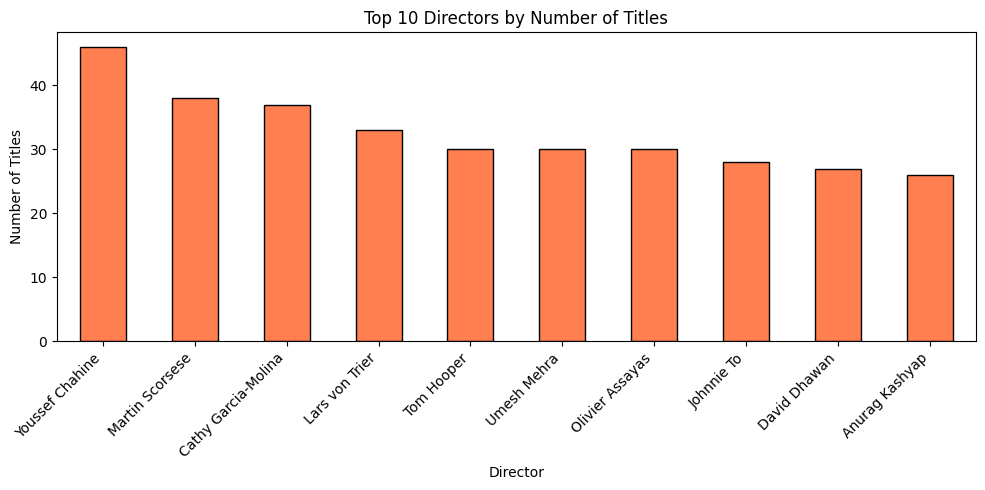

In [12]:
df_clean['director'] = df_clean['director'].fillna('Unknown')
df_clean['director_list'] = df_clean['director'].apply(lambda x: [d.strip() for d in str(x).split(',')])
df_dir = df_clean.explode('director_list')

top_directors = df_dir['director_list'].value_counts().drop('Unknown').head(10)

top_directors.plot(kind='bar', color='coral', edgecolor='black', figsize=(10,5))
plt.title("Top 10 Directors by Number of Titles")
plt.xlabel("Director")
plt.ylabel("Number of Titles")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
